# Bite Size Bayes

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Review

[The previous notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/10_joint.ipynb) I introduced cross tabulation, joint distributions, conditional disrtribution, and marginal distributions.

In this notebook, we'll apply these ideas to Bayesian inference.

But first I want to introduce a computational tool we will need, outer operations.

## Outer operations

Suppose you have two sequences, like `t1` and `t2`:

In [2]:
t1 = [1,3,5]

In [3]:
t2 = [2,4]

Many useful operations can be expressed in the form of an "outer operation" of these sequences.

The most common outer operation is the outer product, which computes the product of every pair of values, one from each sequence.

For example, here is the outer product of `t1` and `t2`:

In [4]:
a = np.multiply.outer(t1, t2)
a

array([[ 2,  4],
       [ 6, 12],
       [10, 20]])

We can understand this result more easily if we put it in a DataFrame:

In [5]:
pd.DataFrame(a, index=t1, columns=t2)

,2,4
1,2,4
3,6,12
5,10,20


The values from `t1` appear along the rows of the result; the values from `t2` appear along the columns.  

Each element of the result is the product of an element from `t1` and an element from `t2`.

The outer sum is similar, except that each element is the *sum* of an element from `t1` and an element from `t2`.

In [6]:
a = np.add.outer(t1, t2)
a

array([[3, 5],
       [5, 7],
       [7, 9]])

In [7]:
pd.DataFrame(a, index=t1, columns=t2)

,2,4
1,3,5
3,5,7
5,7,9


We can do the same thing with almost any operation.  For example, the "outer greater than" operation compares each element from `t1` to each element of `t2`; the result is an array of Boolean values.

In [8]:
a = np.greater.outer(t1, t2)
a

array([[False, False],
       [ True, False],
       [ True,  True]])

In [9]:
pd.DataFrame(a, index=t1, columns=t2)

,2,4
1,False,False
3,True,False
5,True,True


These outer operations work with Python lists and tuples, and NumPy arrays, but not Pandas Series.

However, the following function works with Pandas Series, and puts the result into a DataFrame.

In [10]:
def outer_product(s1, s2):
    """Compute the outer product of two Series.
    
    First Series goes down the rows;
    second goes across the columns.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    a = np.multiply.outer(s1.to_numpy(), s2.to_numpy())
    return pd.DataFrame(a, index=s1.index, columns=s2.index)

It might not be obvious yet why these operations are useful, but we'll see some examples soon.

With that, we are ready to take on a new Bayesian problem.

## How tall is A?

Suppose I choose two people from the population of adult males in the U.S.; I'll call them A and B.  If we see that A taller than B, how tall is A?

To answer this question:

1. I'll use background information about the height of men in the U.S. to form a prior distribution of height,

2. I'll construct a joint distribution of height for A and B, and update it with the information that A is taller, and 

3. I'll extract from the posterior joint distribution the posterior distribution of height for A.

In the U.S. the average height of male adults in 178 cm and the standard deviation is 7.7 cm.  The distribution is not exactly normal, because nothing in the real world is, but the normal distribution is a pretty good model of the actual distribution, so we can use it as a prior distribution for A and B.

Here's an array of equally-spaced values from roughly 3 standard deviations below the mean to 3 standard deviations above.

In [11]:
mean = 178
std = 7.7

xs = np.arange(mean-24, mean+24, 0.5)

SciPy provides a function called `norm` that represents a normal distribution with a given mean and standard deviation, and provides `pdf`, which evaluates the probability distribution function (PDF), which we will use as the prior probabilities.

In [12]:
from scipy.stats import norm

ps = norm(mean, std).pdf(xs)

I'll store the `xs` and `ps` in a Series that represents the prior PMF.

In [13]:
prior = pd.Series(ps, index=xs)

And normalize it:

In [14]:
prior /= prior.sum()

And here's what it looks like.

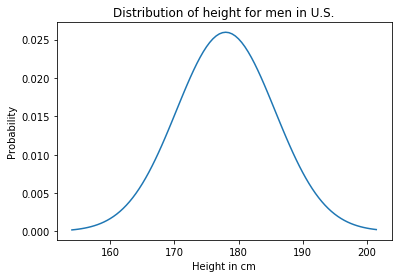

In [15]:
prior.plot()

plt.xlabel('Height in cm')
plt.ylabel('Probability')
plt.title('Distribution of height for men in U.S.');

We can think of this prior distribution as the marginal distribution for A and B, but what we want is the joint probability of their heights.

## Joint distribution

As we saw in the previous notebook, it is not *generally* possible to construct a joint distribution if we only have the marginals, because the marginals don't contain information about correlations between the variables.

However, in the special case where there are no correlations, or they are small enough to ignore, it *is* possible to construct the joint distribution.

To see how, let's consider one element of the joint distribution,

$P(A_y~\mathrm{and}~B_x)$

which is the probability that `A` is $y$ cm tall and `B` is $x$ cm tall.  We can rewrite this conjuction in terms of conditional probability:

$P(A_y)~P(B_x~|~A_y)$

We can compute $P(A_y)$ from the marginal distribution, but how should we compute the conditional probability, $P(B_x~|~A_y)$?

In this case, the heights of `A` and `B` are "independent", which means that knowing the height of `A` provides no additional information about the height of `B`.

And that means that the conditional probability, $P(B_x~|~A_y)$, is just the marginal probability $P(B_y)$.

Which means that in this case, the joint probability is just the product of the marginal probabilities.

$P(A_y~\mathrm{and}~B_x) = P(A_y)~P(B_x)$

Now, to compute the joint distribution, we have to compute this product for all values of $x$ and $y$.  And we can do that by computing the outer product of the marginal distributions, like this:

In [16]:
joint = outer_product(prior, prior)
joint.shape

(96, 96)

If the prior is normalized, the joint prior should also be normalized.

In [17]:
joint.to_numpy().sum()

1.0

The following function uses `pcolormesh` to plot the joint distribution.

Recall that `outer_product` puts the values of `A` along the rows and the values of `B` across the columns.

In [18]:
def plot_joint(joint):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    plt.pcolormesh(joint.index, joint.index, joint)    
    plt.ylabel('A height in cm')
    plt.xlabel('B height in cm')


And here's what the result looks like.

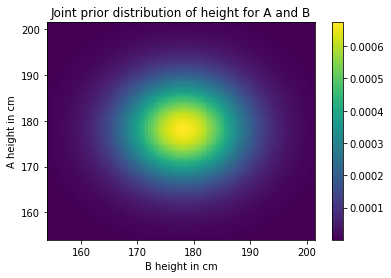

In [19]:
plot_joint(joint)
plt.colorbar()
plt.title('Joint prior distribution of height for A and B');

As you might expect, the probability is highest near the mean and drops off away from the mean.

Another way to visualize the joint distribution is a contour plot.

In [20]:
def plot_contour(joint):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    plt.contour(joint.index, joint.index, joint)
    plt.ylabel('A height in cm')
    plt.xlabel('B height in cm')

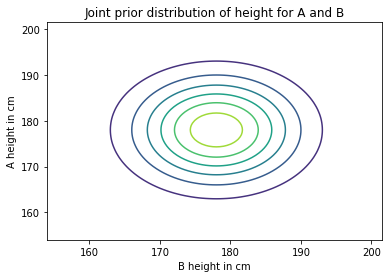

In [21]:
plot_contour(joint)
plt.title('Joint prior distribution of height for A and B');

Each circle represents a level of equal probability.  

## Likelihood

Now that we have a joint PMF that represents the prior distribution, we can update it with the data, which is that `A` is taller than `B`.

Each element in the joint distribution represents a hypothesis about the heights of `A` and `B`; for example:

* The element `(180, 170)` represents the hypothesis that `A` is 180 cm tall and `B` is 170 cm tall.  Under this hypothesis, the probability that `A` is taller than `B` is 1.

* The element `(170, 180)` represents the hypothesis that `A` is 170 cm tall and `B` is 180 cm tall.  Under this hypothesis, the probability that `A` is taller than `B` is 0.

To compute the likelihood of every pair of values, we can extract the values from the prior, like this:

In [22]:
Y = prior.index.to_numpy()
X = prior.index.to_numpy()

And then apply the `outer` version of `np.greater`, which compares every element of `Y` (height of `A`) to every element of `X` (height of `B`).

In [23]:
a = np.greater.outer(Y, X)

The result is an array, which we can put in a DataFrame with the corresponding `index` and `columns`.

In [24]:
likelihood = pd.DataFrame(a, index=Y, columns=X)

Here's what it looks like:

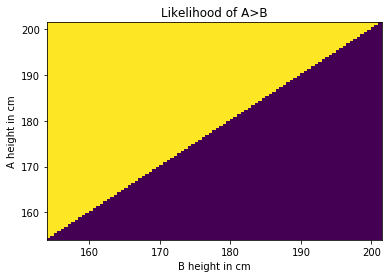

In [25]:
plot_joint(likelihood)
plt.title('Likelihood of A>B');

The likelihood of the data is 1 where `Y>X` and 0 otherwise.

## The update

We have a prior, we have a likelihood, and we are ready for the update.  As usual, the unnormalized posterior is the product of the prior and the likelihood.

In [26]:
unnorm_posterior = joint * likelihood

And we can get the normalized posterior by dividing through by the total.

In [27]:
total = unnorm_posterior.to_numpy().sum()
joint_posterior = unnorm_posterior / total
total

0.49080747821526977

The total probability of the data is a little less than $1/2$.

Here's what the normalized posterior looks like.

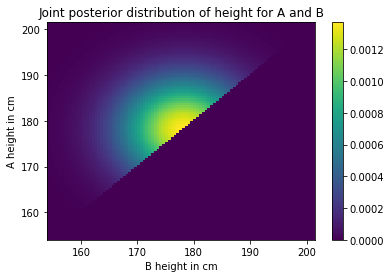

In [28]:
plot_joint(joint_posterior)
plt.colorbar()

plt.title('Joint posterior distribution of height for A and B');

It looks like a sunrise as seen from the deck of a [heeling sailboat](https://en.wikipedia.org/wiki/Sailing#Heeling).

## The marginals

From the posterior joint distribution we can extract the posterior marginal distribution of `A` and `B`.

In [29]:
def marginal(joint, axis):
    """Compute a marginal distribution.
    
    axis=0 returns the marginal distribution of the second variable
    axis=1 returns the marginal distribution of the first variable
    
    joint: DataFrame representing a joint PMF
    axis: int axis to sum along
    
    returns: Series representing a marginal PMF
    """
    return joint.sum(axis=axis)

In [30]:
marginal_A = marginal(joint_posterior, axis=1)
marginal_B = marginal(joint_posterior, axis=0)

Here's what they look like.

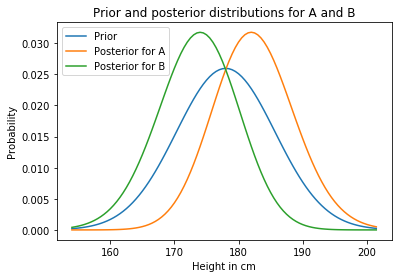

In [31]:
prior.plot(label='Prior')
marginal_A.plot(label='Posterior for A')
marginal_B.plot(label='Posterior for B')

plt.xlabel('Height in cm')
plt.ylabel('Probability')
plt.title('Prior and posterior distributions for A and B')
plt.legend();

As you might expect, the posterior distribution for `A` is shifted to the right and the posterior distribution for `B` is shifted to the left.

We can summarize the results by computing the posterior means:

In [32]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [33]:
pmf_mean(prior)

177.99516026921506

In [34]:
pmf_mean(marginal_A), pmf_mean(marginal_B)

(182.38728123421686, 173.60286000233387)

Based on the observation that `A` is taller than `B`, we are inclined to believe that `A` is a little taller than average, and `B` is a little shorter.

Notice that the posterior distribution are a little taller and narrower than the prior.  We can quantify that my computing their standard deviations.

In [35]:
def pmf_std(pmf):
    """Compute the standard deviation of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    deviation = pmf.index - pmf_mean(pmf)
    var = np.sum(deviation**2 * pmf)
    return np.sqrt(var)

In [36]:
pmf_std(prior), pmf_std(marginal_A)

(7.624924796641578, 6.27046117764547)

The standard deviation of the posterior distributions are a little smaller, which means we are a little more certain about the heights of `A` and `B` after we compare them.

## Conditional posteriors

Now suppose we measure `B` and find that he is 185 cm tall.  What does that tell us about `A`?

We can answer that question by extracting the conditional posterior distribution for `A`, conditioned on `B=185`.

Possible heights for `A` run down the rows of the joint PMF, so each row is an unnormalized posterior distribution conditioned on `A`.

And possible heights for `B` run across the columns, so each column is an unnormalized posterior distribution conditioned on `B`.

So we can condition on `B` by selecting a column and normalizing it.

In [37]:
cond_A = joint_posterior[185].copy()
cond_A /= cond_A.sum()

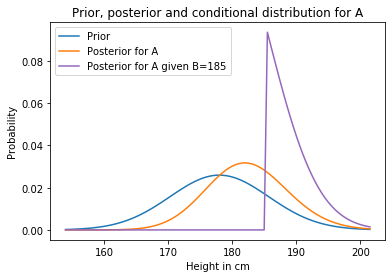

In [38]:
prior.plot(label='Prior')
marginal_A.plot(label='Posterior for A')
cond_A.plot(label='Posterior for A given B=185', color='C4')

plt.xlabel('Height in cm')
plt.ylabel('Probability')
plt.title('Prior, posterior and conditional distribution for A')
plt.legend();

The posterior conditional distribution is cut off at 185 cm, because we have established that `A` is taller than `B` and `B` is 185 cm.

And the posterior conditional is substantially different from the unconditional posterior; that is, for each value of $y$

$P(A_y | B_x) \ne P(A_y)$

which means that in the posterior distribution, `A` and `B` are not independent.

## Elo rating

[The Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system) is a way to quantify the skill level of players for games like chess.

It is based on a model of the relationship between the ratings of players and the outcome of a game.  Specifically, if $R_A$ is the rating of player $A$ and $R_B$ is the rating of player $B$, the probability that $A$ beats $B$ is given by the [logistic function](https://en.wikipedia.org/wiki/Logistic_function):

$P(A~\mathrm{wins}) = 1 / (1 + 10^{(R_B-R_A)/400})$

The parameters $10$ and $400$ are arbitrary choices that determine the range of the ratings.  In chess, values range from 100 to 2800.

Notice that the probability of winning depends only on the difference in rankings.  As an example, if $R_A$ exceeds $R_B$ by 100 points, the probability that $A$ wins is

In [52]:
1 / (1 + 10**(-100/400))

0.6400649998028851

**Exercise:** Suppose `A` has a current rating of 1600, but we are not sure it is accurate.  We could describe their true rating with a normal distribution with mean 1600 and standard deviation 100, to indicate our uncertainty.

And suppose `B` has a current rating of 1800, with the same level of uncertaintly.

Finally, `A` and `B` play and `A` wins.  How should we update their ratings?

To answer this question:

1. Construct prior distributions for `A` and `B`.

2. Use them to construct a joint distribution, assuming that the prior distributions are independent.

3. Use the logistic function above to compute the likelihood of the outcome under each joint hypothesis.  Hint: use `np.subtract.outer`.

4. Use the joint prior and likelihood to compute the joint posterior. 

5. Extract and plot the marginal posteriors for `A` and `B`.

6. Compute the posterior means for `A` and `B`.  How much should their ratings change based on this outcome?

In [40]:
# Solution

xs = np.arange(1300, 2100, 10)

ps = norm(1600, 100).pdf(xs)
prior_A = pd.Series(ps, index=xs)
prior_A /= prior_A.sum()

ps = norm(1800, 100).pdf(xs)
prior_B = pd.Series(ps, index=xs)
prior_B /= prior_B.sum()

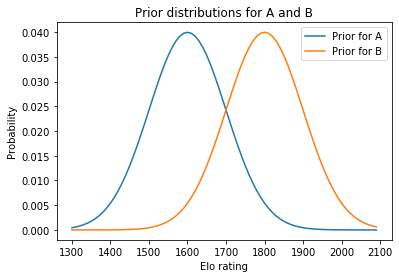

In [41]:
# Solution

prior_A.plot(label='Prior for A')
prior_B.plot(label='Prior for B')

plt.xlabel('Elo rating')
plt.ylabel('Probability')
plt.title('Prior distributions for A and B')
plt.legend();

In [42]:
# Solution

joint = outer_product(prior_A, prior_B)
joint.shape

(80, 80)

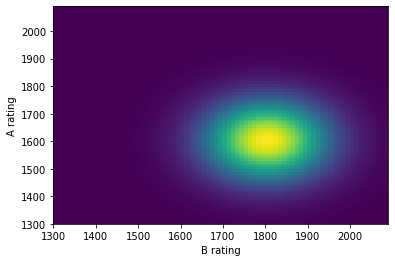

In [43]:
# Solution

plt.pcolormesh(joint.index, joint.index, joint)    
plt.ylabel('A rating')
plt.xlabel('B rating');

In [44]:
# Solution

diff = np.subtract.outer(prior_A.index, prior_B.index)

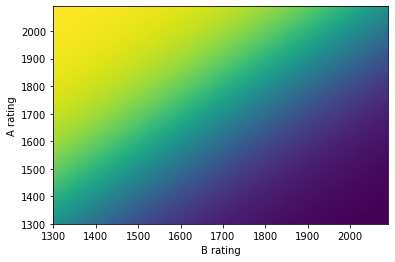

In [45]:
# Solution

likelihood = 1 / (1 + 10**(-diff/400))

plt.pcolormesh(joint.index, joint.index, likelihood)    
plt.ylabel('A rating')
plt.xlabel('B rating');

In [46]:
# Solution

joint_posterior = joint * likelihood
joint_posterior /= joint_posterior.to_numpy().sum()

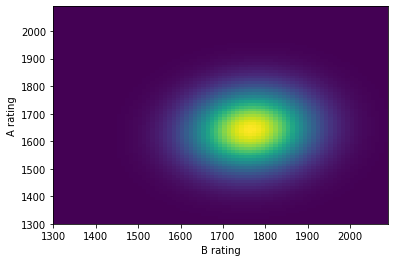

In [47]:
# Solution

plt.pcolormesh(joint.index, joint.index, joint_posterior)    
plt.ylabel('A rating')
plt.xlabel('B rating');

In [48]:
# Solution

marginal_A = marginal(joint_posterior, axis=1)
marginal_B = marginal(joint_posterior, axis=0)

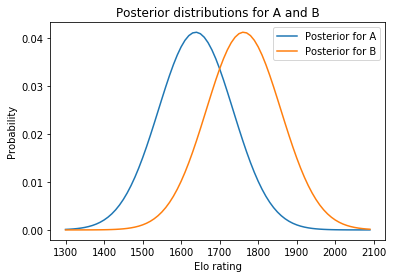

In [49]:
# Solution

marginal_A.plot(label='Posterior for A')
marginal_B.plot(label='Posterior for B')

plt.xlabel('Elo rating')
plt.ylabel('Probability')
plt.title('Posterior distributions for A and B')
plt.legend();

In [50]:
# Solution

pmf_mean(marginal_A), pmf_mean(marginal_B)

(1637.7213735750752, 1762.2426343832121)

In [51]:
# Solution

pmf_std(prior_A), pmf_std(marginal_A)

(99.41698581100648, 96.86560602798998)

## Summary

In this notebook I started with the "outer" operations, like outer product and outer sum; then we used them to construct a joint distribution.

In general, you cannot construct a joint distrubution from two marginal distributions, but in the special case where the distributions are independent, you can.

We extended the Bayesian update process we've seen in previous notebook and applied it to a joint distribution.  Then from the posterior joint distribution we extracted posterior marginal distributions and posterior conditional distributions.

As an exercise, you had a chance to apply the same process to a slightly more difficult problem, updating Elo ratings based on the outcome of a chess game.

[In the next notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/12_sum.ipynb) we'll get back to a problem we left half-finished: the Euro problem.